In [3]:
pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.1/308.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ruptures: filename=ruptures-1.1.9-cp311-cp311-macosx_11_0_arm64.whl size=463631 sha256=c790d4ac13395cf729a60e2ed2524dd0a0fd2a3079b8b88c47833cf5f1a1735a
  Stored in directory: /Users/yuvrajsinghsrinet/Library/Caches/pip/wheels/91/4b/b2/08e23635050124c9dfc36d6a86ca63f025a8aa86c31a7e011d
Successfully built ruptures
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from statsforecast.models import HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SimpleExponentialSmoothing, SimpleExponentialSmoothingOptimized, Holt, HoltWinters, DynamicOptimizedTheta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
import os
#Import evaluation metrics from scikit-learn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# statsmodel api
import statsmodels.api as sm
from statsmodels.tsa.ardl import *
from statsmodels.tsa.stattools import adfuller, kpss
# sklearn
from sklearn.model_selection import *
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.model_selection import train_test_split
from statsforecast.arima import arima_string
from statsforecast.models import ARIMA as sf_arima
from statsmodels.tsa.arima.model import ARIMA as sm_arima
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.base import datetools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import ruptures as rpt

/opt/anaconda3/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import warnings

#Command to not show warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the data
df = pd.read_csv('price_index.csv')
df.head()

,Date,All Commodity Price Index,Non-Fuel Price Index,Food and Beverage Price Index,Food Price Index,Agricultural Raw Materials Index,Fuel Energy Index
0,01-01-1992,52.876718,83.329026,96.099228,97.986897,87.013457,35.061062
1,01-02-1992,53.020784,83.705932,95.672402,98.213935,86.862877,35.068909
2,01-03-1992,52.736939,83.715638,94.918650,97.461684,88.126997,34.613325
3,01-04-1992,54.270214,84.333553,92.970648,95.456964,94.438511,36.682118
4,01-05-1992,55.577815,85.305726,94.400447,97.297458,95.535433,38.185955


In [4]:
df.tail()

,Date,All Commodity Price Index,Non-Fuel Price Index,Food and Beverage Price Index,Food Price Index,Agricultural Raw Materials Index,Fuel Energy Index
266,01-03-2014,183.061099,169.769282,182.950004,182.946798,144.646383,190.837274
267,01-04-2014,184.610653,171.700210,184.785349,184.808072,143.264693,192.163710
268,01-05-2014,184.267474,168.720801,182.229476,182.471620,142.001281,193.362817
269,01-06-2014,185.159780,164.574478,176.184596,175.952550,140.387565,197.202896
270,01-07-2014,181.278086,165.009048,173.334042,172.584604,139.769862,190.796037


## Data Formatting

In [5]:
#placing the date time index

df['ds'] = pd.to_datetime(df['Date'], dayfirst='False')
df = df.drop('Date', axis=1)

#Setting unique_id as 1
df["unique_id"] = "1"
#df.set_index('ds', inplace=True)

df.head()

,All Commodity Price Index,Non-Fuel Price Index,Food and Beverage Price Index,Food Price Index,Agricultural Raw Materials Index,Fuel Energy Index,ds,unique_id
0,52.876718,83.329026,96.099228,97.986897,87.013457,35.061062,1992-01-01,1
1,53.020784,83.705932,95.672402,98.213935,86.862877,35.068909,1992-02-01,1
2,52.736939,83.715638,94.918650,97.461684,88.126997,34.613325,1992-03-01,1
3,54.270214,84.333553,92.970648,95.456964,94.438511,36.682118,1992-04-01,1
4,55.577815,85.305726,94.400447,97.297458,95.535433,38.185955,1992-05-01,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   All Commodity Price Index         271 non-null    float64       
 1   Non-Fuel Price Index              271 non-null    float64       
 2   Food and Beverage Price Index     271 non-null    float64       
 3   Food Price Index                  271 non-null    float64       
 4   Agricultural Raw Materials Index  271 non-null    float64       
 5   Fuel Energy Index                 271 non-null    float64       
 6   ds                                271 non-null    datetime64[ns]
 7   unique_id                         271 non-null    object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 17.1+ KB


In [7]:
print(df.describe())

       All Commodity Price Index  Non-Fuel Price Index  \
count                 271.000000            271.000000   
mean                   99.057397            113.431369   
min                    41.971597             70.367583   
25%                    57.879954             83.858163   
50%                    65.726409             98.840995   
75%                   140.833056            143.529489   
max                   219.899500            206.616862   
std                    52.491614             36.701186   

       Food and Beverage Price Index  Food Price Index  \
count                     271.000000        271.000000   
mean                      117.202771        117.056063   
min                        75.831061         76.044302   
25%                        93.125685         94.675172   
50%                       104.629987        102.358608   
75%                       140.478664        138.175502   
max                       196.266380        194.060266   
std          

## Correlation Analysis

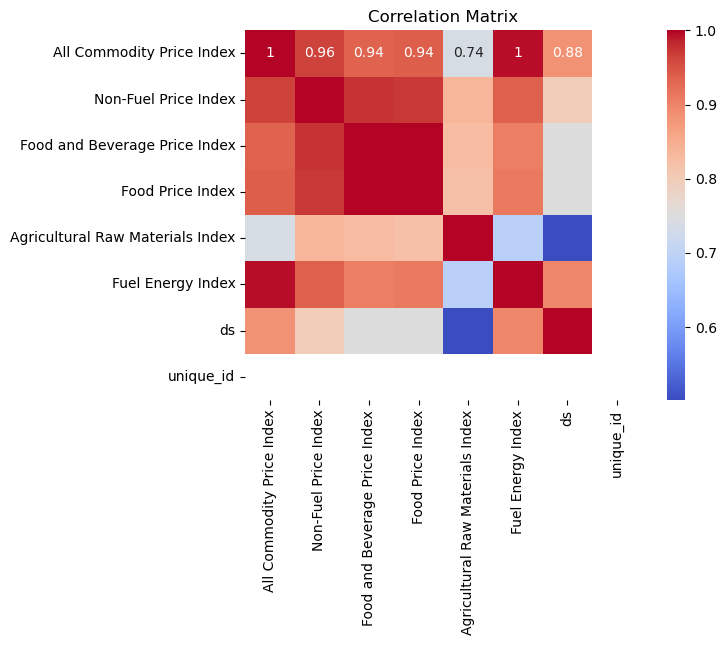

In [8]:
# Checking for correlations
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [9]:
# Extracting month and year from date
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month

## Box Plots of data

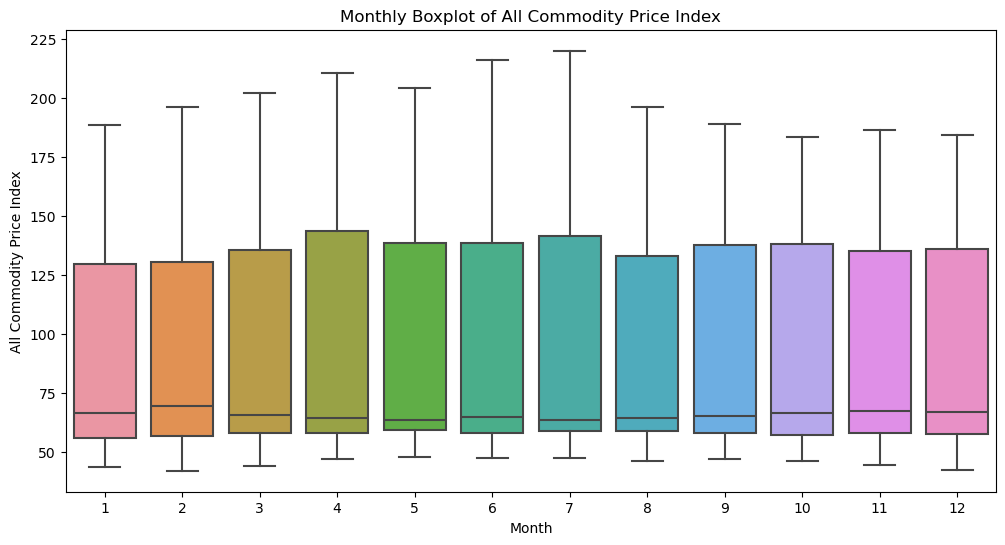

In [10]:
# Monthly box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='All Commodity Price Index', data=df)
plt.title('Monthly Boxplot of All Commodity Price Index')
plt.xlabel('Month')
plt.ylabel('All Commodity Price Index')
plt.show()

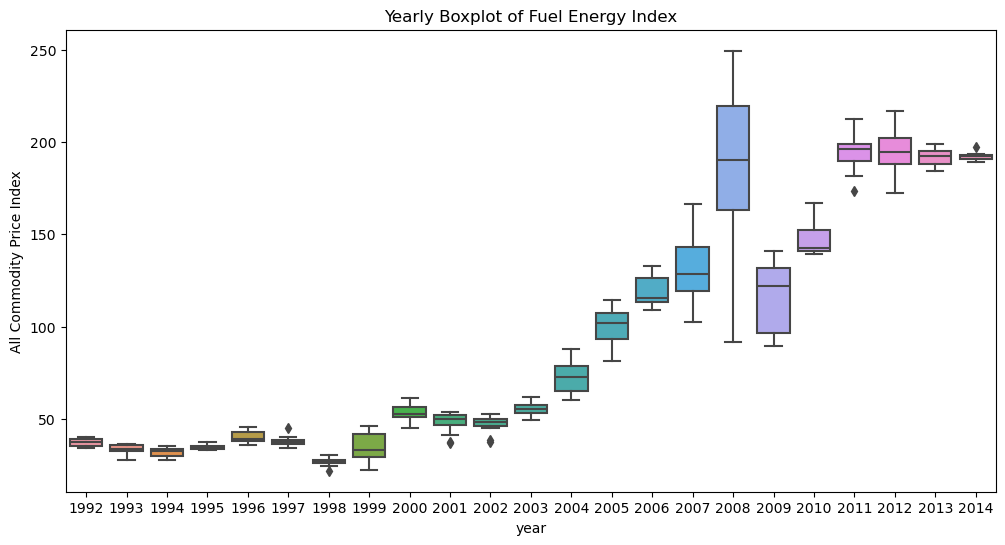

In [128]:
# Monthly box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='Fuel Energy Index', data=df)
plt.title('Yearly Boxplot of Fuel Energy Index')
plt.xlabel('year')
plt.ylabel('All Commodity Price Index')
plt.show()

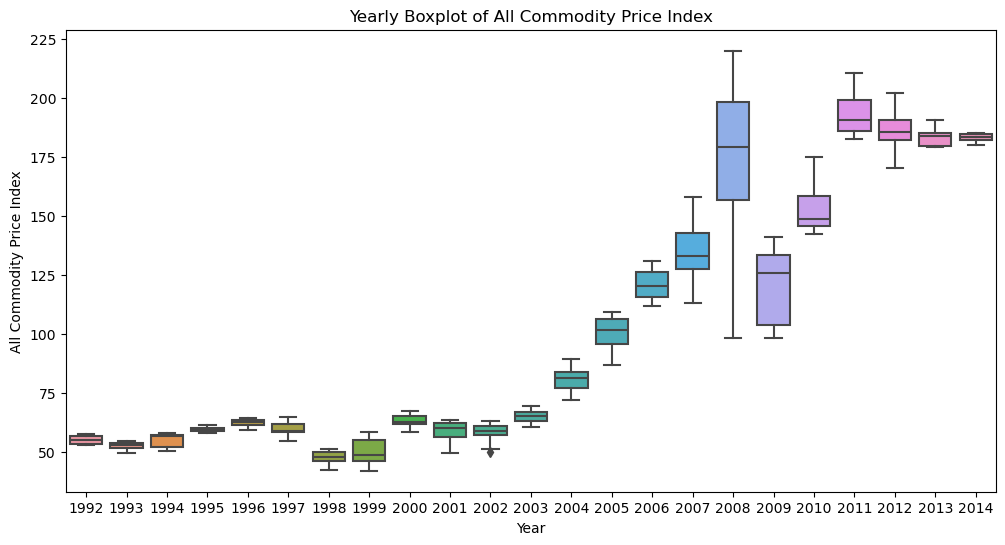

In [11]:
# Yearly box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='All Commodity Price Index', data=df)
plt.title('Yearly Boxplot of All Commodity Price Index')
plt.xlabel('Year')
plt.ylabel('All Commodity Price Index')
plt.show()

In [12]:
df.head(1)

,All Commodity Price Index,Non-Fuel Price Index,Food and Beverage Price Index,Food Price Index,Agricultural Raw Materials Index,Fuel Energy Index,ds,unique_id,year,month
0,52.876718,83.329026,96.099228,97.986897,87.013457,35.061062,1992-01-01,1,1992,1


## Line Plot of all Time Series Data

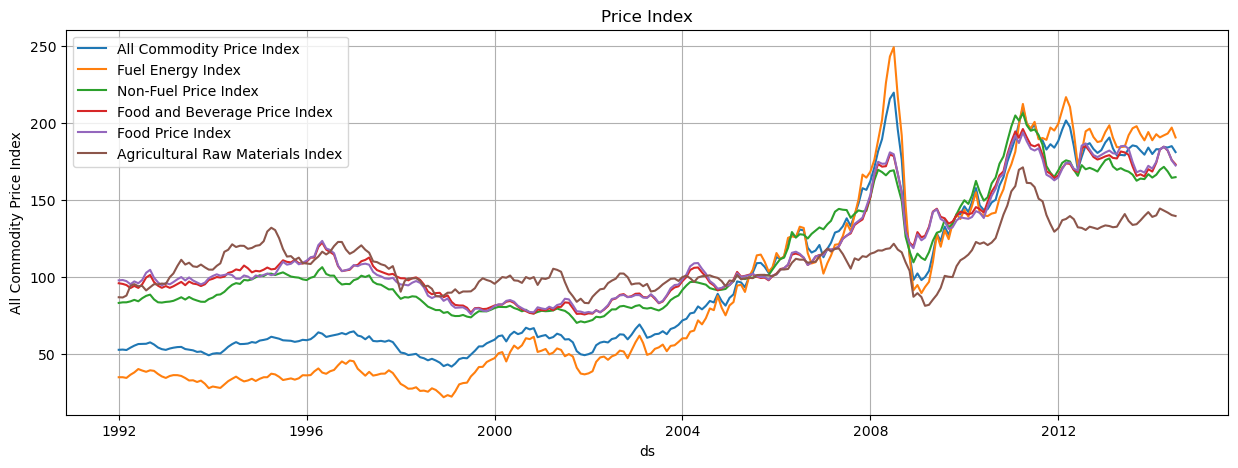

In [13]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
sns.lineplot(data=df, x="ds", y="All Commodity Price Index" ,label="All Commodity Price Index")
sns.lineplot(data=df, x="ds", y="Fuel Energy Index" ,label="Fuel Energy Index")
sns.lineplot(data=df, x="ds", y="Non-Fuel Price Index" ,label="Non-Fuel Price Index")
sns.lineplot(data=df, x="ds", y="Food and Beverage Price Index" ,label="Food and Beverage Price Index")
sns.lineplot(data=df, x="ds", y="Food Price Index" ,label="Food Price Index")
sns.lineplot(data=df, x="ds", y="Agricultural Raw Materials Index" ,label="Agricultural Raw Materials Index")
plt.title("Price Index")

plt.grid()
plt.show()

## Scatter Plot of Selected Price Index

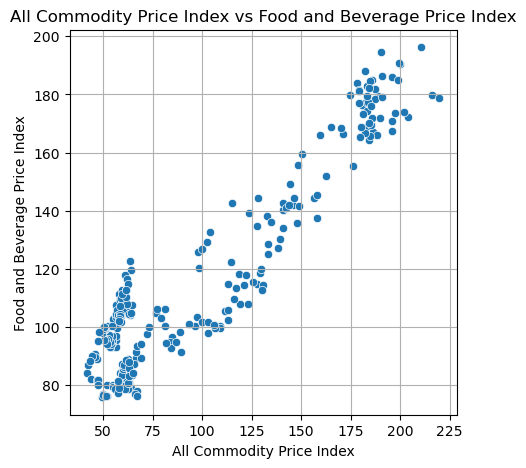

In [14]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x="All Commodity Price Index", y="Food and Beverage Price Index" )
plt.title("All Commodity Price Index vs Food and Beverage Price Index")
plt.grid()
plt.show()

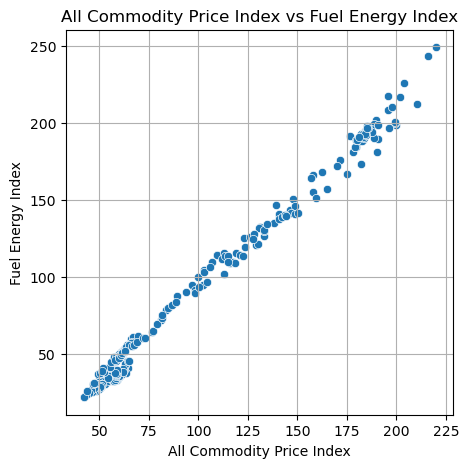

In [15]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x="All Commodity Price Index", y="Fuel Energy Index" )
plt.title("All Commodity Price Index vs Fuel Energy Index")
plt.grid()
plt.show()

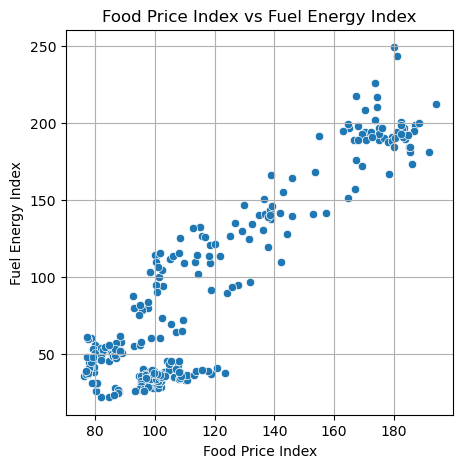

In [16]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x="Food Price Index", y="Fuel Energy Index" )
plt.title("Food Price Index vs Fuel Energy Index")
plt.grid()
plt.show()

# Forecasting (Univariate) of Fuel Energy Index

In [17]:
#taking relevant data
df_1= df[["ds","unique_id","Fuel Energy Index"]]

In [18]:
#formatting data
df_1["y"]=df_1["Fuel Energy Index"]
df_1 = df_1.drop('Fuel Energy Index', axis=1)
df_1.head()

,ds,unique_id,y
0,1992-01-01,1,35.061062
1,1992-02-01,1,35.068909
2,1992-03-01,1,34.613325
3,1992-04-01,1,36.682118
4,1992-05-01,1,38.185955


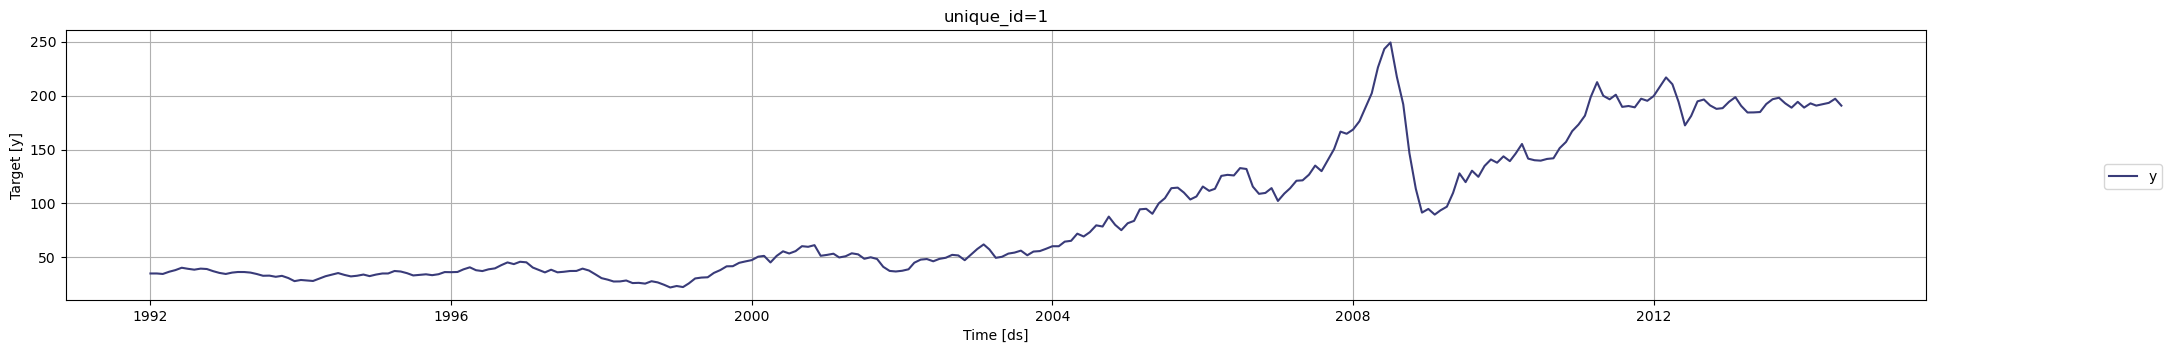

In [19]:
#Plotting the data
StatsForecast.plot(df_1)

### Decomposition and Analysis of Data

In [20]:
# Classical additive decomposition
additive_decomposition = seasonal_decompose(df_1['y'], model='additive',period=13)

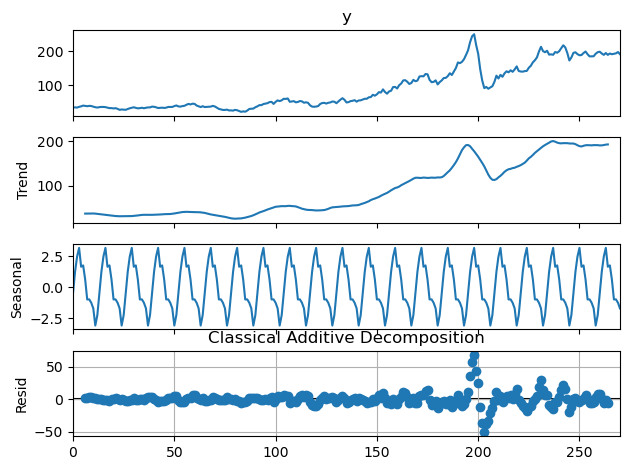

In [21]:
#plot the additive decomposition data
additive_decomposition.plot()
plt.title('Classical Additive Decomposition')

plt.grid()
plt.show()

In [22]:
len(df_1)

271

In [23]:
df_1

,ds,unique_id,y
0,1992-01-01,1,35.061062
1,1992-02-01,1,35.068909
2,1992-03-01,1,34.613325
3,1992-04-01,1,36.682118
4,1992-05-01,1,38.185955
...,...,...,...
266,2014-03-01,1,190.837274
267,2014-04-01,1,192.163710
268,2014-05-01,1,193.362817
269,2014-06-01,1,197.202896


### Train Test Split

In [24]:
#Defining start and end dates for training and testing periods
train_start = "1992-01-01"
train_end = "2011-12-31"
test_start = "2012-01-01"
test_end = "2014-07-01"

#Splitting the data
train_df = df_1[(df_1["ds"] >= train_start) & (df_1["ds"] <= train_end)]
test_df = df_1[(df_1["ds"] >= test_start) & (df_1["ds"] <= test_end)]

print(len(train_df))
print(len(test_df))

240
31


In [25]:
train_df.head()

,ds,unique_id,y
0,1992-01-01,1,35.061062
1,1992-02-01,1,35.068909
2,1992-03-01,1,34.613325
3,1992-04-01,1,36.682118
4,1992-05-01,1,38.185955


In [26]:
train_df.tail()

,ds,unique_id,y
235,2011-08-01,1,189.649441
236,2011-09-01,1,190.448613
237,2011-10-01,1,189.215516
238,2011-11-01,1,197.215668
239,2011-12-01,1,195.279103


### Plotting Train Test Line Plot on Graph

Text(0.5, 1.0, 'Fuel Energy Index Data')

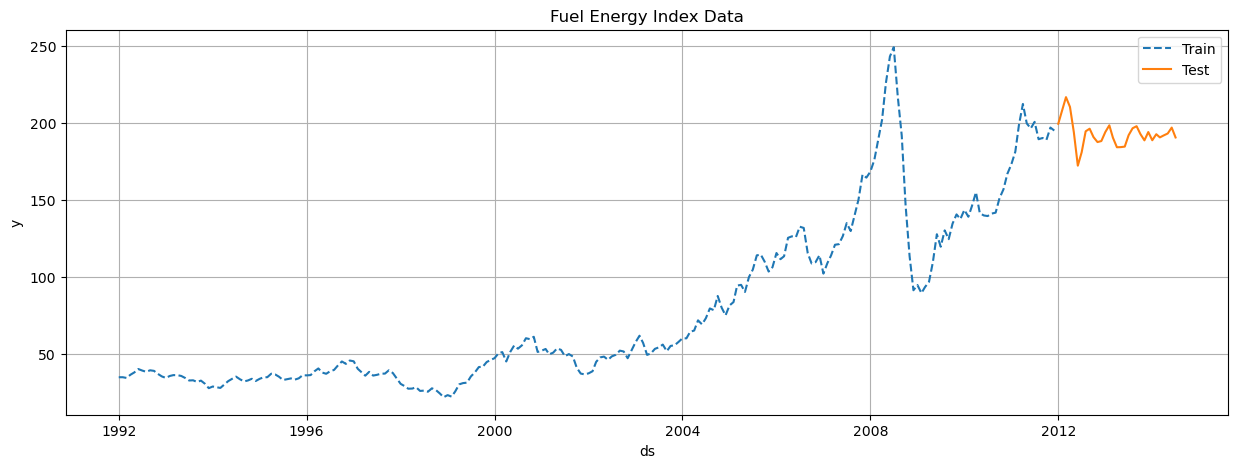

In [27]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
sns.lineplot(data=train_df, x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(data=test_df, x="ds", y="y", label="Test")

plt.grid()
plt.title("Fuel Energy Index Data")

In [28]:
#Forecast horizon = number of days that we want to forecast into the future
horizon = len(test_df)
horizon

31

In [29]:
#Initialize empty models list that we'll add models to
models = []

#Seasonal Naive model
models.append(SeasonalNaive(season_length=12, alias="Seasonal Naive"))

#Holt-Winter's Model or Triple Exponential Smoothing
# l= 12 as monthly
models.append(HoltWinters(season_length=12, alias = "HoltWinters"))

#Theta Model
models.append(DynamicOptimizedTheta(season_length=12, decomposition_type="additive", alias="Theta"))

print(models)

[Seasonal Naive, HoltWinters, Theta]


In [30]:
sf = StatsForecast(models=models,df=train_df,
                   freq='M', # Monthly frequency
                   n_jobs=-1)

### Fitted Values from Model

In [31]:
#Fit the model
sf.fit()

StatsForecast(models=[Seasonal Naive,HoltWinters,Theta])

In [32]:
#See fitted values from the models
result_snaive = sf.fitted_[0,0].model_
result_holt = sf.fitted_[0,1].model_
result_theta = sf.fitted_[0,2].model_

#Extract only fitted values from the models into a dataframe
fitted_df = pd.DataFrame()

fitted_df["fitted_snaive"] = result_snaive.get("fitted")
fitted_df["fitted_holt"] = result_holt.get("fitted")
fitted_df["fitted_theta"] = result_theta.get("fitted")

#Also have the timestamp
fitted_df["ds"]=train_df["ds"]

### Plotting the Model Fitted Data vs Actual Data

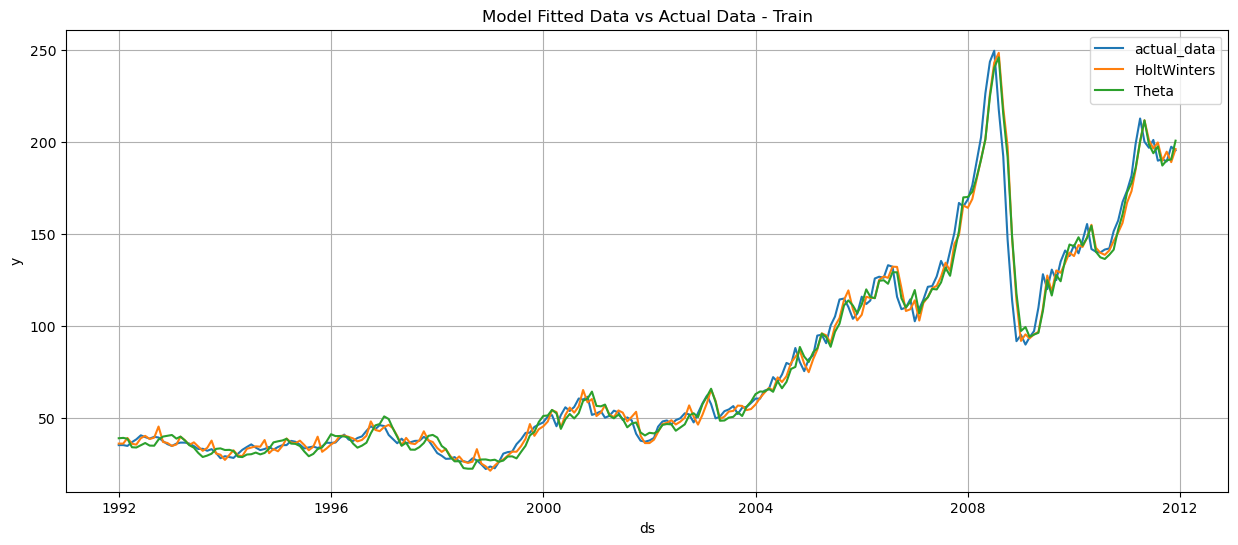

In [33]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,6))
sns.lineplot(data=train_df, x="ds", y="y", label="actual_data")
sns.lineplot(data=fitted_df, x="ds", y="fitted_holt", label="HoltWinters")
sns.lineplot(data=fitted_df, x="ds", y="fitted_theta", label="Theta")
plt.grid()
plt.title("Model Fitted Data vs Actual Data - Train")
plt.show()

### Forecast using the Models

In [34]:
#horizon=31
warnings.filterwarnings('ignore')
forecasts_df = sf.forecast(df=train_df, h=31)
forecasts_df.head()

,ds,Seasonal Naive,HoltWinters,Theta
unique_id,,,,
1,2011-12-31,173.296112,195.270615,196.932907
1,2012-01-31,181.529999,195.364746,197.747223
1,2012-02-29,198.746613,198.966217,201.087601
1,2012-03-31,212.574097,200.724304,204.193329
1,2012-04-30,199.947372,199.691040,205.598862


In [35]:
len(forecasts_df)

31

In [36]:
actual_ts = test_df["y"]

#Create a list with the model aliases
model_names = [str(model) for model in models]

#Initialize error dataframe
error_df = pd.DataFrame(columns=model_names, index=["MAE","MAPE","MSE"])

#Print the errors for each model
for model in model_names:
    
    #Evaluate the model MAE
    model_mae = np.round(mean_absolute_error(actual_ts, forecasts_df[model]),2)
   
    #Evaluate the model MAPE
    model_mape = np.round(100*mean_absolute_percentage_error(actual_ts, forecasts_df[model]),2)
    
    #Evaluate the model MSE
    model_mse = np.round(mean_squared_error(actual_ts, forecasts_df[model]),2)

    #Save errors in error dataframe
    error_df.loc[:,model] = (model_mae, model_mape, model_mse)

In [37]:
error_df

,Seasonal Naive,HoltWinters,Theta
MAE,11.72,13.49,20.4
MAPE,6.1,7.07,10.7
MSE,200.52,223.18,489.28


In [38]:
forecasts_df['actual_data'] = test_df['y'].values
forecasts_df.head()

,ds,Seasonal Naive,HoltWinters,Theta,actual_data
unique_id,,,,,
1,2011-12-31,173.296112,195.270615,196.932907,199.691044
1,2012-01-31,181.529999,195.364746,197.747223,208.646372
1,2012-02-29,198.746613,198.966217,201.087601,216.976382
1,2012-03-31,212.574097,200.724304,204.193329,210.621955
1,2012-04-30,199.947372,199.691040,205.598862,194.234473


In [39]:
forecasts_df.tail()

,ds,Seasonal Naive,HoltWinters,Theta,actual_data
unique_id,,,,,
1,2014-02-28,198.746613,209.933380,218.221909,190.837274
1,2014-03-31,212.574097,211.691467,221.404297,192.163710
1,2014-04-30,199.947372,210.658203,222.884689,193.362817
1,2014-05-31,196.648834,211.233276,225.030380,197.202896
1,2014-06-30,200.919266,210.880753,226.281036,190.796037


### Plotting Model Data vs Actual Data

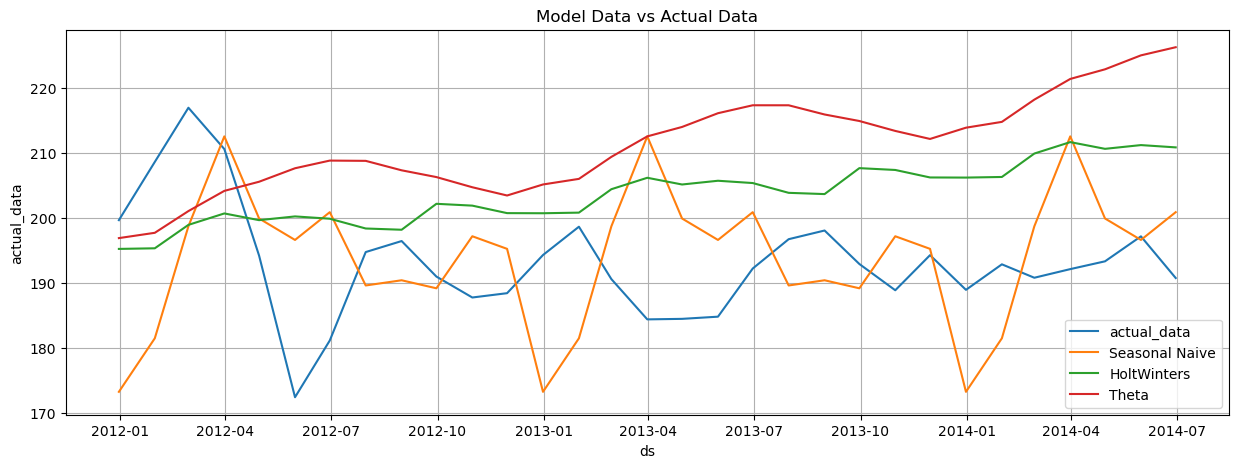

In [40]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
sns.lineplot(data=forecasts_df, x="ds", y="actual_data", label="actual_data")
sns.lineplot(data=forecasts_df, x="ds", y="Seasonal Naive", label="Seasonal Naive")
sns.lineplot(data=forecasts_df, x="ds", y="HoltWinters", label="HoltWinters")
sns.lineplot(data=forecasts_df, x="ds", y="Theta", label="Theta")

plt.grid()

plt.title("Model Data vs Actual Data")
plt.show()

## Autocorrelation and Partial Autocorrelation

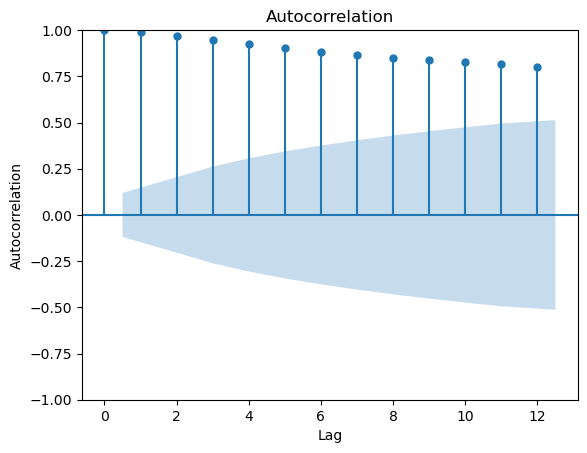

In [41]:
#Autocorrelation plot
plot_acf(df_1["y"], lags=12)
plt.ylabel("Autocorrelation")
plt.xlabel("Lag")
plt.show()

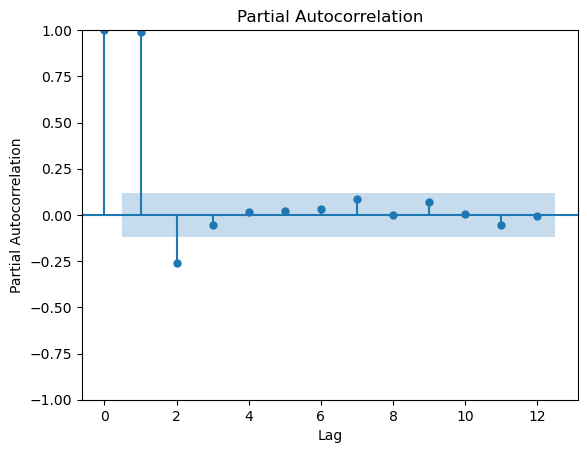

In [42]:
#Partial Autocorrelation plot
plot_pacf(df_1["y"], lags=12)
plt.ylabel("Partial Autocorrelation")
plt.xlabel("Lag")
plt.show()

## Stationarity

In [43]:
#Augmented Dickey Fuller test
adftest = adfuller(df_1["y"])
adf_stat = adftest[0]
adf_pval = adftest[1]

In [44]:
#Check result
print("stat = %f, pval = %f" % (adf_stat, adf_pval))

stat = -1.262443, pval = 0.646175


In [45]:
#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")


The time series is not stationary at a 5% significance level


In [46]:
#differencing

adftest = adfuller(df_1["y"].diff().dropna())
adf_stat = adftest[0]
adf_pval = adftest[1]

In [47]:
#Check result
print("stat = %f, pval = %f" % (adf_stat, adf_pval))

stat = -7.755318, pval = 0.000000


In [48]:
#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")
    

The time series is stationary at a 5% significance level


## Box Cox

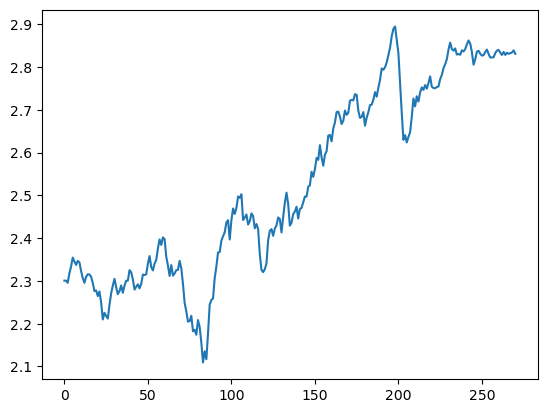

In [49]:
#The boxcox function returns two values, (i) the transformed data and (ii) the optimal lambda
y_boxcox, lamda = boxcox(df_1["y"])

plt.plot(y_boxcox)

In [50]:
#Lambda that maximizes log-likelihood function
lamda

-0.26581906889010753

In [51]:
#Note that time series is not stationary and additional differencing is required
#Augmented Dickey Fuller test
adftest = adfuller(y_boxcox)
adf_pval = adftest[1]

#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")

The time series is not stationary at a 5% significance level


In [52]:
#Note that time series is stationary once additional differencing has been done
#Augmented Dickey Fuller test
adftest = adfuller(np.diff(y_boxcox))
adf_pval = adftest[1]

#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")

The time series is stationary at a 5% significance level


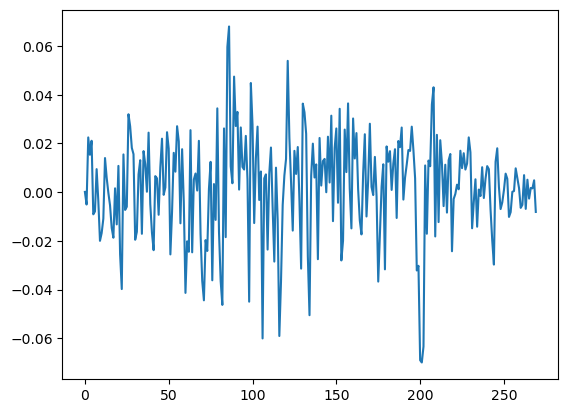

In [53]:
plt.plot(np.diff(y_boxcox))

# ARIMA Model

In [54]:
train_df.head()

,ds,unique_id,y
0,1992-01-01,1,35.061062
1,1992-02-01,1,35.068909
2,1992-03-01,1,34.613325
3,1992-04-01,1,36.682118
4,1992-05-01,1,38.185955


In [55]:
len(test_df)

31

In [56]:
#Augmented Dickey Fuller test
adftest = adfuller(train_df["y"])
adf_stat = adftest[0]
adf_pval = adftest[1]

In [57]:
#Check result
print("stat = %f, pval = %f" % (adf_stat, adf_pval))

stat = 0.399150, pval = 0.981463


In [58]:
#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")

The time series is not stationary at a 5% significance level


In [59]:
#Difference once
train_df["y_diff1"] = train_df["y"].diff()
train_df["y_diff1"].dropna(inplace=True)
train_df["y_diff1"]

0            NaN
1       0.007847
2      -0.455584
3       2.068793
4       1.503838
         ...    
235   -11.269825
236     0.799172
237    -1.233098
238     8.000152
239    -1.936564
Name: y_diff1, Length: 240, dtype: float64

In [60]:
#Repeat Augmented Dickey Fuller test
adftest = adfuller(train_df["y_diff1"].dropna())
adf_stat = adftest[0]
adf_pval = adftest[1]

In [61]:
#Check result
print("stat = %f, pval = %f" % (adf_stat, adf_pval))

stat = -5.960412, pval = 0.000000


In [62]:
#Final result
if adf_pval > 0.05:
    print("The time series is not stationary at a 5% significance level")
else:
    print("The time series is stationary at a 5% significance level")

The time series is stationary at a 5% significance level


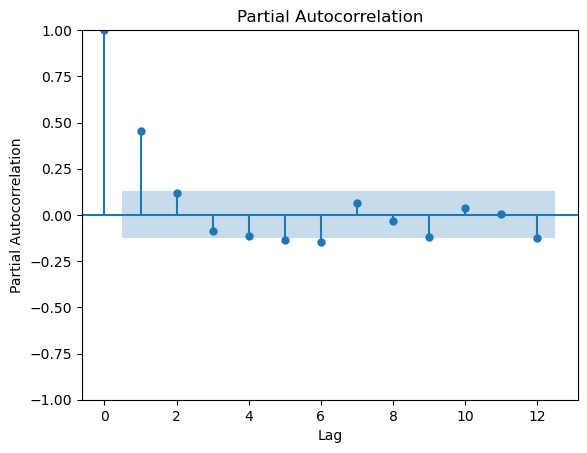

In [63]:
#Get order of autoregressive model - 1 significant lags are seen
plot_pacf(train_df["y_diff1"].dropna(), lags=12)
plt.ylabel("Partial Autocorrelation")
plt.xlabel("Lag")
plt.show()

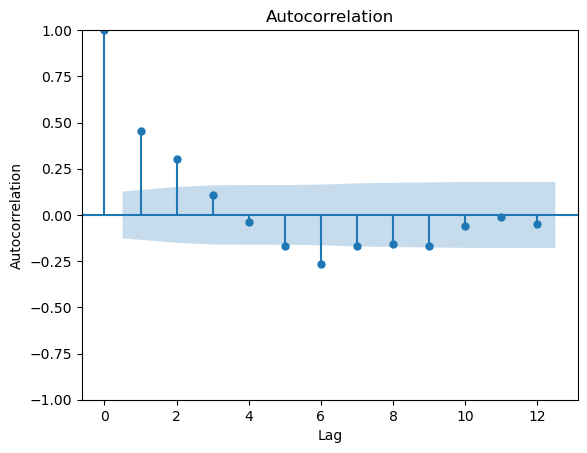

In [64]:
#Get order of moving average model - 2 significant lags are seen
plot_acf(train_df["y_diff1"].dropna(), lags=12)
plt.ylabel("Autocorrelation")
plt.xlabel("Lag")
plt.show()

In [65]:
#Fit ARIMA model
arima_model = sm_arima(train_df['y'],order=(1,1,2)).fit()

In [66]:
#Summary of ARIMA model
arima_model.summary().tables[0]

Dep. Variable:,y,No. Observations:,240
Model:,"ARIMA(1, 1, 2)",Log Likelihood,-779.106
Date:,"Thu, 20 Jun 2024",AIC,1566.212
Time:,20:11:12,BIC,1580.118
Sample:,0,HQIC,1571.816
,- 240,,
Covariance Type:,opg,,


In [67]:
#Summary of ARIMA model
arima_model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.4718,0.113,4.179,0.000,0.251,0.693
ma.L1,-0.0720,0.115,-0.624,0.533,-0.298,0.154
ma.L2,0.1390,0.066,2.116,0.034,0.010,0.268
sigma2,39.6710,2.130,18.628,0.000,35.497,43.845


In [68]:
#Summary of ARIMA model
arima_model.summary().tables[2]

Ljung-Box (L1) (Q):,0.00,Jarque-Bera (JB):,514.49
Prob(Q):,0.95,Prob(JB):,0.00
Heteroskedasticity (H):,33.24,Skew:,-1.46
Prob(H) (two-sided):,0.00,Kurtosis:,9.57


### Conduct Residual Analysis

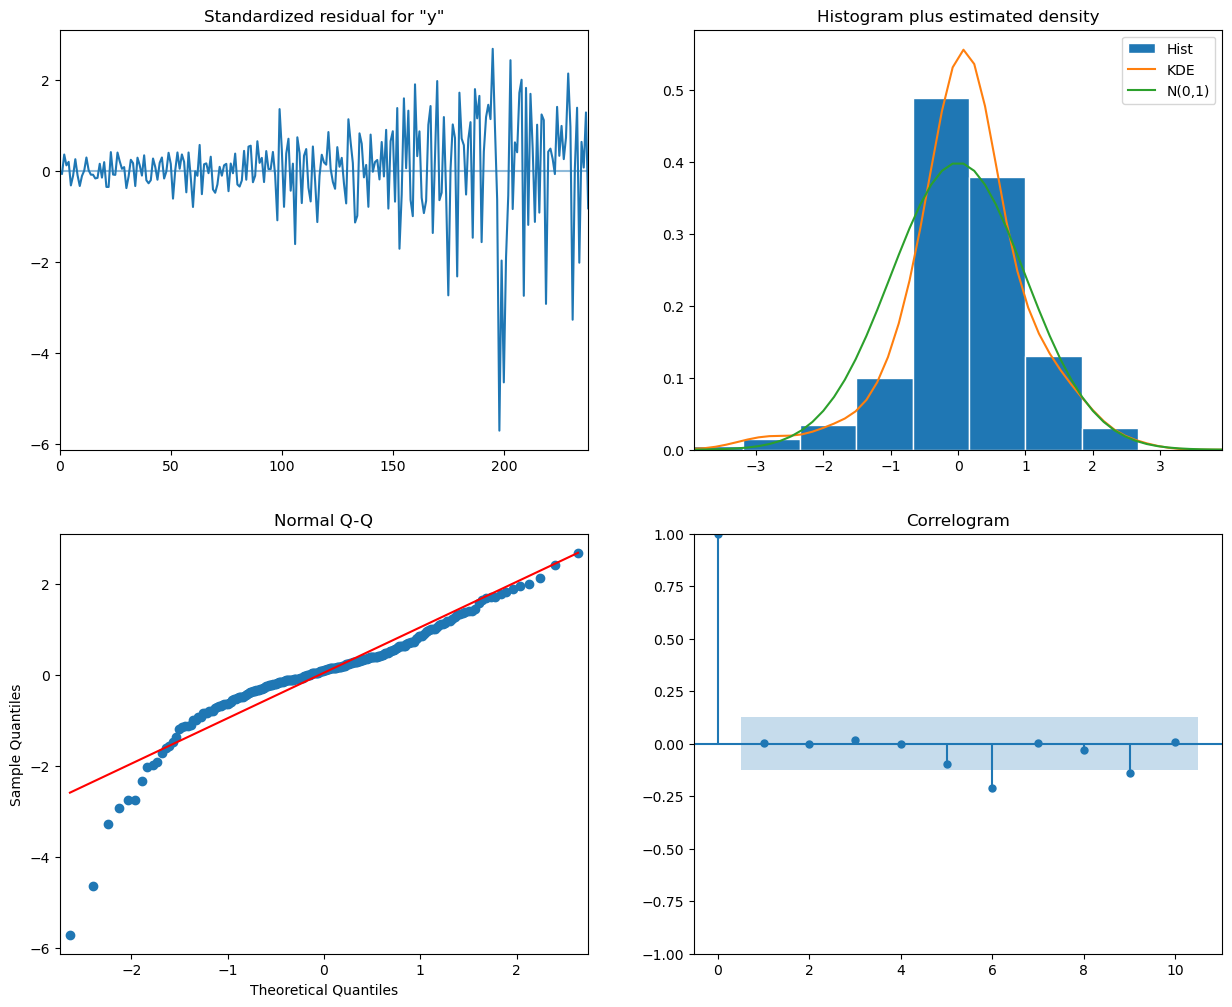

In [69]:
arima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

## Forecast

In [70]:
#Get forecast for 31 months
arima_forecast = arima_model.forecast(31)

In [71]:
arima_forecast.values

array([195.85921169, 195.41143636, 195.20018036, 195.10051185,
       195.05348923, 195.03130442, 195.02083784, 195.01589981,
       195.0135701 , 195.01247096, 195.0119524 , 195.01170775,
       195.01159233, 195.01153787, 195.01151218, 195.01150006,
       195.01149434, 195.01149164, 195.01149037, 195.01148977,
       195.01148948, 195.01148935, 195.01148929, 195.01148926,
       195.01148924, 195.01148924, 195.01148923, 195.01148923,
       195.01148923, 195.01148923, 195.01148923])

In [72]:
len(forecasts_df)

31

In [73]:
len(arima_forecast)

31

In [74]:
#add arima forecasts to forecast data
forecasts_df['arima_forecast'] = arima_forecast.values

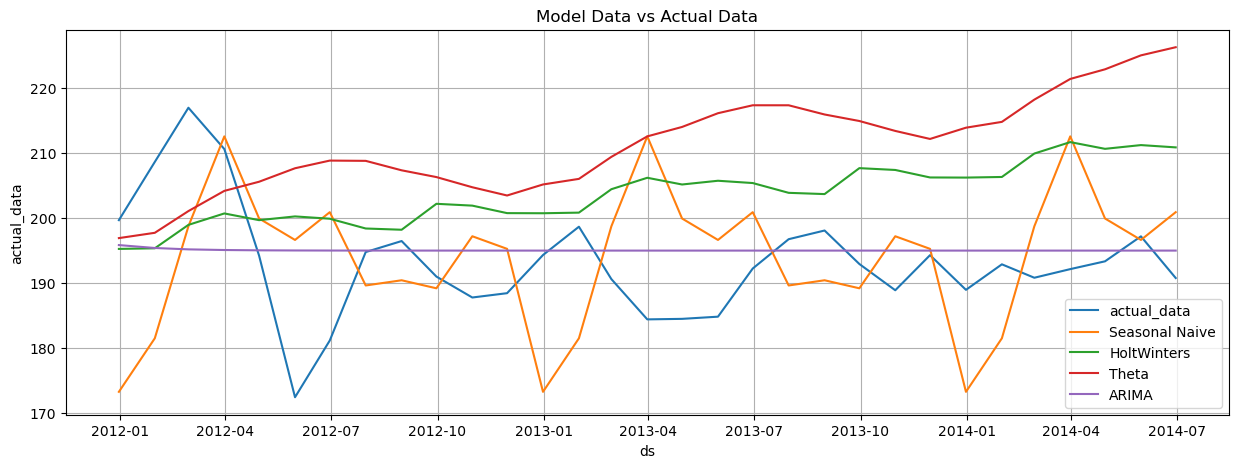

In [75]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
sns.lineplot(data=forecasts_df, x="ds", y="actual_data", label="actual_data")
sns.lineplot(data=forecasts_df, x="ds", y="Seasonal Naive", label="Seasonal Naive")
sns.lineplot(data=forecasts_df, x="ds", y="HoltWinters", label="HoltWinters")
sns.lineplot(data=forecasts_df, x="ds", y="Theta", label="Theta")
sns.lineplot(data=forecasts_df, x="ds", y="arima_forecast", label="ARIMA")

plt.grid()

plt.title("Model Data vs Actual Data")
plt.show()

In [76]:
#Evaluate the model MAE
model_mae = np.round(mean_absolute_error(forecasts_df["actual_data"], forecasts_df["arima_forecast"]),2)
#Evaluate the model MAPE
model_mape = np.round(100*mean_absolute_percentage_error(forecasts_df["actual_data"], forecasts_df["arima_forecast"]),2)
#Evaluate the model MSE
model_mse = np.round(mean_squared_error(forecasts_df["actual_data"], forecasts_df["arima_forecast"]),2)

In [77]:
#Save errors in error dataframe
error_df.loc[:,"ARIMA"] = (model_mae, model_mape, model_mse)
error_df

,Seasonal Naive,HoltWinters,Theta,ARIMA
MAE,11.72,13.49,20.4,6.15
MAPE,6.1,7.07,10.7,3.20
MSE,200.52,223.18,489.28,71.98


## AutoARIMA with Nixtla

In [78]:
train_df=train_df.drop('y_diff1',axis=1)
train_df.head()

,ds,unique_id,y
0,1992-01-01,1,35.061062
1,1992-02-01,1,35.068909
2,1992-03-01,1,34.613325
3,1992-04-01,1,36.682118
4,1992-05-01,1,38.185955


In [79]:
sf_2 = StatsForecast(df=train_df,
                   models=[AutoARIMA(season_length=12)],  #monthly data hence season length= 12
                   freq='M',  #monthly
                   n_jobs=-1,
                   )

sf_2.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [80]:
#Access dictionary of the AutoARIMA model's parameters
model_params = sf_2.fitted_[0][0].model_

### Conduct Residual Analysis

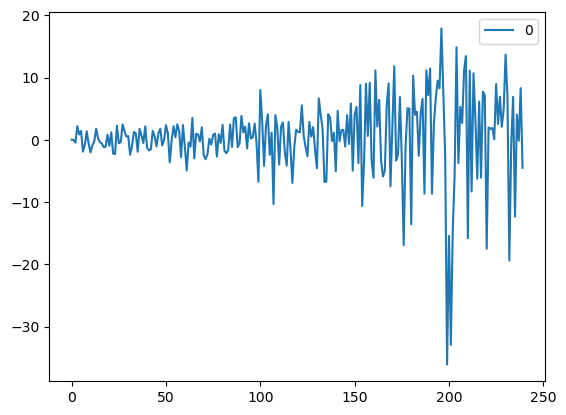

In [81]:
#Residual analysis
residuals = pd.DataFrame(model_params["residuals"])
residuals.plot()
plt.show()

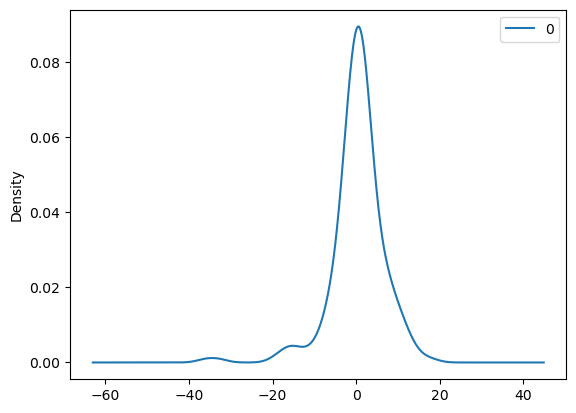

In [82]:
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

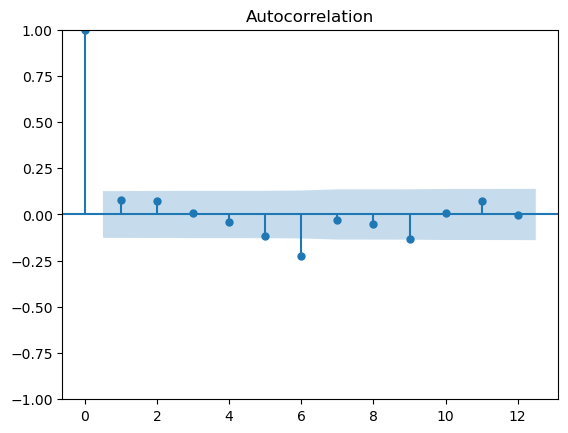

In [83]:
#Plot Autocorrelation of Residuals
plot_acf(residuals, lags=12)
plt.show()

In [84]:
# Summary statistics of residuals
print(residuals.describe())

                0
count  240.000000
mean     0.362093
std      6.332664
min    -36.052396
25%     -1.894083
50%      0.680979
75%      2.913590
max     17.890489


In [85]:
#Get forecast
auto_arima_forecast = sf_2.forecast(h=31, level=[95])
forecasts_df['AutoARIMA']=auto_arima_forecast['AutoARIMA']
forecasts_df.head()

,ds,Seasonal Naive,HoltWinters,Theta,actual_data,arima_forecast,AutoARIMA
unique_id,,,,,,,
1,2011-12-31,173.296112,195.270615,196.932907,199.691044,195.859212,195.600555
1,2012-01-31,181.529999,195.364746,197.747223,208.646372,195.411436,195.473145
1,2012-02-29,198.746613,198.966217,201.087601,216.976382,195.200180,195.469345
1,2012-03-31,212.574097,200.724304,204.193329,210.621955,195.100512,195.452576
1,2012-04-30,199.947372,199.691040,205.598862,194.234473,195.053489,195.446472


In [86]:
#Evaluate the model MAE
model_mae = np.round(mean_absolute_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA"]),2)
#Evaluate the model MAPE
model_mape = np.round(100*mean_absolute_percentage_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA"]),2)
#Evaluate the model MSE
model_mse = np.round(mean_squared_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA"]),2)

In [87]:
#Save errors in error dataframe
error_df.loc[:,"AutoARIMA"] = (model_mae, model_mape, model_mse)
error_df

,Seasonal Naive,HoltWinters,Theta,ARIMA,AutoARIMA
MAE,11.72,13.49,20.4,6.15,6.37
MAPE,6.1,7.07,10.7,3.20,3.32
MSE,200.52,223.18,489.28,71.98,74.47


### Plotting Model Data vs Actual Data

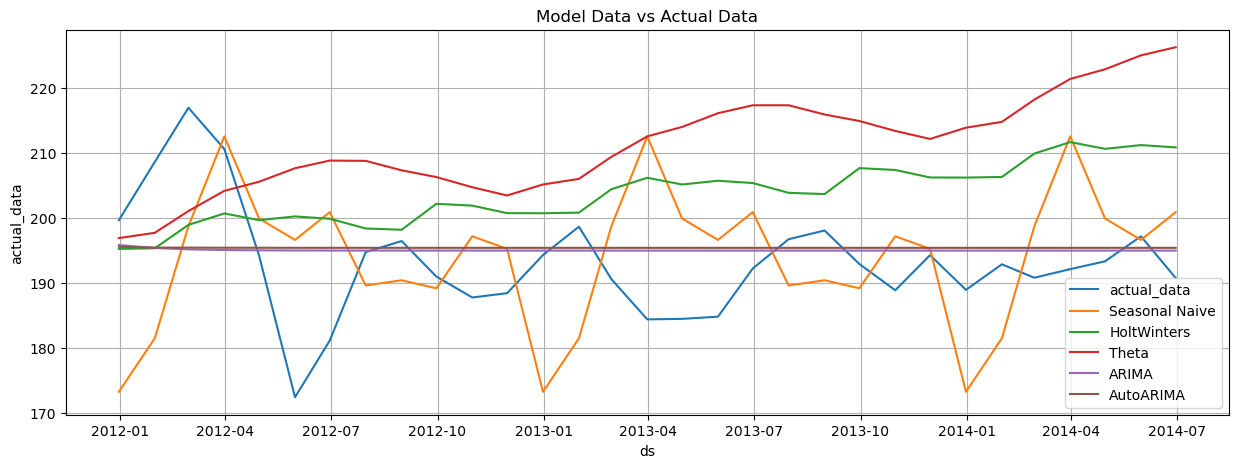

In [88]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
sns.lineplot(data=forecasts_df, x="ds", y="actual_data", label="actual_data")
sns.lineplot(data=forecasts_df, x="ds", y="Seasonal Naive", label="Seasonal Naive")
sns.lineplot(data=forecasts_df, x="ds", y="HoltWinters", label="HoltWinters")
sns.lineplot(data=forecasts_df, x="ds", y="Theta", label="Theta")
sns.lineplot(data=forecasts_df, x="ds", y="arima_forecast", label="ARIMA")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA", label="AutoARIMA")

plt.grid()

plt.title("Model Data vs Actual Data")
plt.show()

## AutoARIMA with Nixtla Multivariate : Fuel Price from All Commodity Price Index

In [89]:
df.head(2)

,All Commodity Price Index,Non-Fuel Price Index,Food and Beverage Price Index,Food Price Index,Agricultural Raw Materials Index,Fuel Energy Index,ds,unique_id,year,month
0,52.876718,83.329026,96.099228,97.986897,87.013457,35.061062,1992-01-01,1,1992,1
1,53.020784,83.705932,95.672402,98.213935,86.862877,35.068909,1992-02-01,1,1992,2


In [90]:
#Simple data preprocessing for Nixtla
df_nix = df[["Fuel Energy Index", "All Commodity Price Index","ds","unique_id"]]
df_nix.columns = ["y","All Commodity Price Index","ds","unique_id"]
df_nix.head()

,y,All Commodity Price Index,ds,unique_id
0,35.061062,52.876718,1992-01-01,1
1,35.068909,53.020784,1992-02-01,1
2,34.613325,52.736939,1992-03-01,1
3,36.682118,54.270214,1992-04-01,1
4,38.185955,55.577815,1992-05-01,1


In [91]:
#Splitting the data
train_df_nix = df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df_nix = df_nix[(df_1["ds"] >= test_start) & (df_nix["ds"] <= test_end)]
train_df_nix.head()

,y,All Commodity Price Index,ds,unique_id
0,35.061062,52.876718,1992-01-01,1
1,35.068909,53.020784,1992-02-01,1
2,34.613325,52.736939,1992-03-01,1
3,36.682118,54.270214,1992-04-01,1
4,38.185955,55.577815,1992-05-01,1


In [92]:
test_df_nix.head()

,y,All Commodity Price Index,ds,unique_id
240,199.691044,188.490251,2012-01-01,1
241,208.646372,195.978029,2012-02-01,1
242,216.976382,201.829861,2012-03-01,1
243,210.621955,197.546841,2012-04-01,1
244,194.234473,185.218124,2012-05-01,1


In [93]:
sf_3 = StatsForecast(df=train_df_nix,
                   models=[AutoARIMA(season_length=12)],
                   freq='M',  
                   n_jobs=-1,
                   )
sf_3.fit(train_df_nix)

StatsForecast(models=[AutoARIMA])

In [94]:
model_params_exog = sf_3.fitted_[0][0].model_

### Conduct Residual Analysis

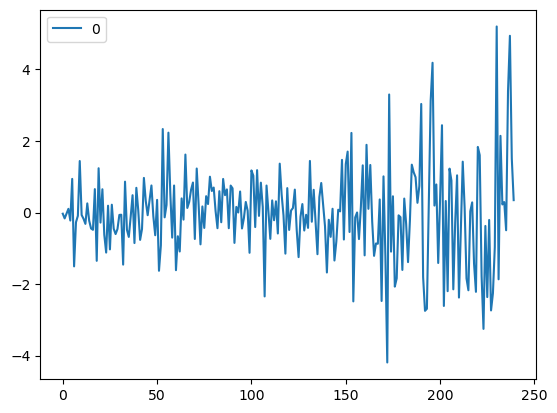

In [95]:
#Residual analysis
residuals = pd.DataFrame(model_params_exog["residuals"])
residuals.plot()
plt.show()

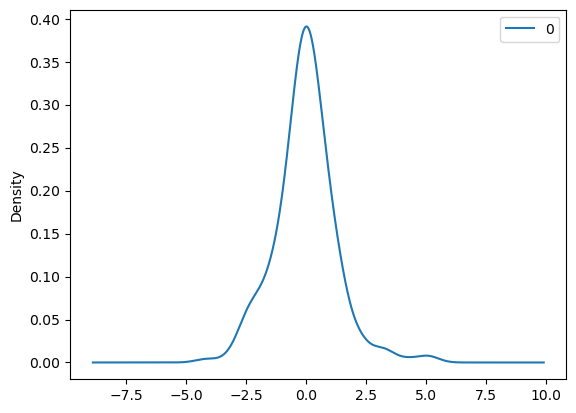

In [96]:
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

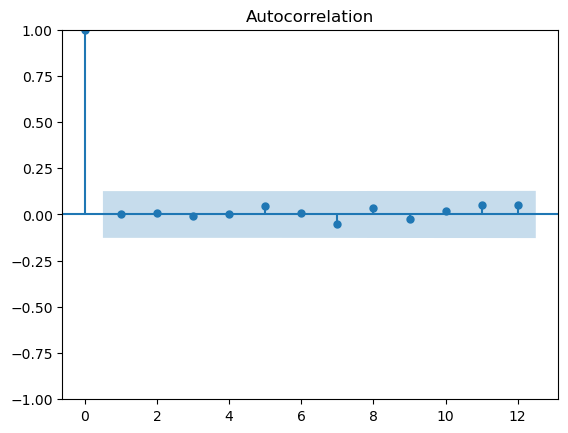

In [97]:
#Plot Autocorrelation of Residuals
plot_acf(residuals, lags=12)
plt.show()

In [98]:
# Summary statistics of residuals
print(residuals.describe())

                0
count  240.000000
mean    -0.026234
std      1.281056
min     -4.191479
25%     -0.667545
50%     -0.030055
75%      0.637453
max      5.200249


## Forecast Exogenous Variable

In [99]:
df_exog=train_df_nix[[ "All Commodity Price Index","ds","unique_id"]]
df_exog.columns = ["y","ds","unique_id"]
df_exog

,y,ds,unique_id
0,52.876718,1992-01-01,1
1,53.020784,1992-02-01,1
2,52.736939,1992-03-01,1
3,54.270214,1992-04-01,1
4,55.577815,1992-05-01,1
...,...,...,...
235,190.657713,2011-08-01,1
236,188.803808,2011-09-01,1
237,182.936236,2011-10-01,1
238,186.399903,2011-11-01,1


In [100]:
#Get forecast of  exogenous variable for next 31 months using a HoltWinters method
models_3 = [DynamicOptimizedTheta(season_length=12, decomposition_type="additive", alias="Theta")]
sf_exog = StatsForecast(df=df_exog,
                   models=models_3,
                   freq='M', # monthly frequency
                   n_jobs=-1)

In [101]:
df_forecast_EXOG = pd.DataFrame()
df_forecast_EXOG["ds"] = test_df_nix["ds"]
df_forecast_EXOG["All Commodity Price Index"] = sf_exog.forecast(31)["Theta"].values
df_forecast_EXOG["unique_id"] = 1
df_forecast_EXOG.head()

,ds,All Commodity Price Index,unique_id
240,2012-01-01,185.991547,1
241,2012-02-01,187.033722,1
242,2012-03-01,189.525421,1
243,2012-04-01,192.123611,1
244,2012-05-01,193.214676,1


In [102]:
len(df_forecast_EXOG)

31

In [103]:
#Get forecast
arima_forecast_fuel = sf_3.forecast(h=31, X_df = df_forecast_EXOG)
arima_forecast_fuel.head()

,ds,AutoARIMA
unique_id,,
1,2011-12-31,197.796753
1,2012-01-31,199.140030
1,2012-02-29,202.351608
1,2012-03-31,205.700455
1,2012-04-30,207.106735


In [104]:
forecasts_df['AutoARIMA_Exog_All']=arima_forecast_fuel['AutoARIMA']
forecasts_df.head()

,ds,Seasonal Naive,HoltWinters,Theta,actual_data,arima_forecast,AutoARIMA,AutoARIMA_Exog_All
unique_id,,,,,,,,
1,2011-12-31,173.296112,195.270615,196.932907,199.691044,195.859212,195.600555,197.796753
1,2012-01-31,181.529999,195.364746,197.747223,208.646372,195.411436,195.473145,199.140030
1,2012-02-29,198.746613,198.966217,201.087601,216.976382,195.200180,195.469345,202.351608
1,2012-03-31,212.574097,200.724304,204.193329,210.621955,195.100512,195.452576,205.700455
1,2012-04-30,199.947372,199.691040,205.598862,194.234473,195.053489,195.446472,207.106735


In [105]:
#Evaluate the model MAE
model_mae = np.round(mean_absolute_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA_Exog_All"]),2)
#Evaluate the model MAPE
model_mape = np.round(100*mean_absolute_percentage_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA_Exog_All"]),2)
#Evaluate the model MSE
model_mse = np.round(mean_squared_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA_Exog_All"]),2)

In [106]:
#Save errors in error dataframe
error_df.loc[:,"AutoARIMA_Exog_All"] = (model_mae, model_mape, model_mse)
error_df

,Seasonal Naive,HoltWinters,Theta,ARIMA,AutoARIMA,AutoARIMA_Exog_All
MAE,11.72,13.49,20.4,6.15,6.37,21.26
MAPE,6.1,7.07,10.7,3.20,3.32,11.16
MSE,200.52,223.18,489.28,71.98,74.47,536.49


### Plotting Model Data vs Actual Data

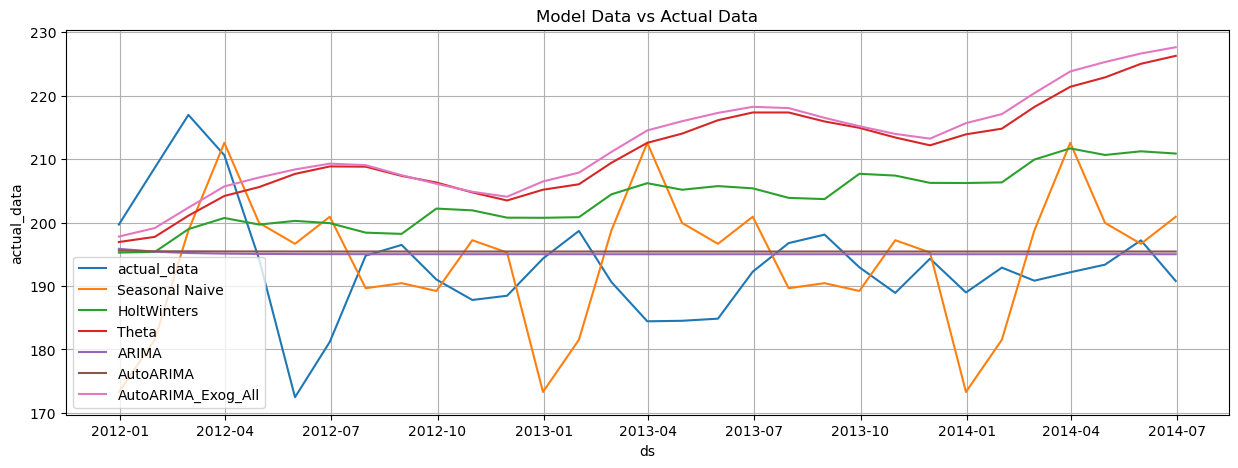

In [107]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
sns.lineplot(data=forecasts_df, x="ds", y="actual_data", label="actual_data")
sns.lineplot(data=forecasts_df, x="ds", y="Seasonal Naive", label="Seasonal Naive")
sns.lineplot(data=forecasts_df, x="ds", y="HoltWinters", label="HoltWinters")
sns.lineplot(data=forecasts_df, x="ds", y="Theta", label="Theta")
sns.lineplot(data=forecasts_df, x="ds", y="arima_forecast", label="ARIMA")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA", label="AutoARIMA")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA_Exog_All", label="AutoARIMA_Exog_All")

plt.grid()

plt.title("Model Data vs Actual Data")
plt.show()

## AutoARIMA with Nixtla Multivariate : Fuel Price from Food Price Index

In [108]:
df.head(1)

,All Commodity Price Index,Non-Fuel Price Index,Food and Beverage Price Index,Food Price Index,Agricultural Raw Materials Index,Fuel Energy Index,ds,unique_id,year,month
0,52.876718,83.329026,96.099228,97.986897,87.013457,35.061062,1992-01-01,1,1992,1


In [109]:
#Simple data preprocessing for Nixtla
df_nix = df[["Fuel Energy Index", "Food Price Index","ds","unique_id"]]
df_nix.columns = ["y","Food Price Index","ds","unique_id"]
df_nix.head()

,y,Food Price Index,ds,unique_id
0,35.061062,97.986897,1992-01-01,1
1,35.068909,98.213935,1992-02-01,1
2,34.613325,97.461684,1992-03-01,1
3,36.682118,95.456964,1992-04-01,1
4,38.185955,97.297458,1992-05-01,1


In [110]:
#Splitting the data
train_df_nix = df_nix[(df_nix["ds"] >= train_start) & (df_nix["ds"] <= train_end)]
test_df_nix = df_nix[(df_1["ds"] >= test_start) & (df_nix["ds"] <= test_end)]

In [111]:
sf_4 = StatsForecast(df=train_df_nix,
                   models=[AutoARIMA(season_length=12)],
                   freq='M',  
                   n_jobs=-1,
                   )

sf_4.fit(train_df_nix)

StatsForecast(models=[AutoARIMA])

In [129]:
model_params_exog = sf_4.fitted_[0][0].model_

### Conduct Residual Analysis

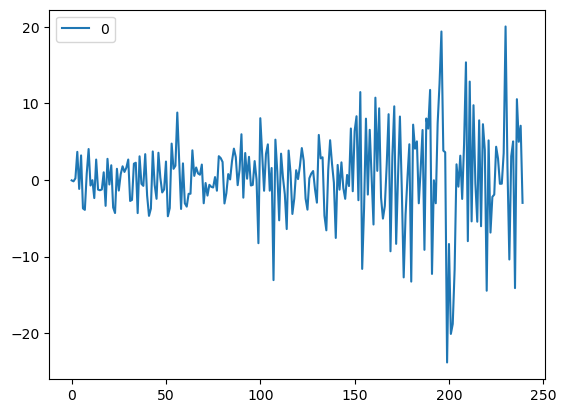

In [130]:
#Residual analysis
residuals = pd.DataFrame(model_params_exog["residuals"])
residuals.plot()
plt.show()

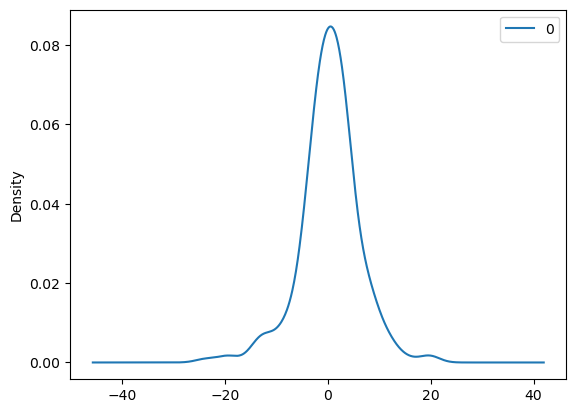

In [131]:
# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

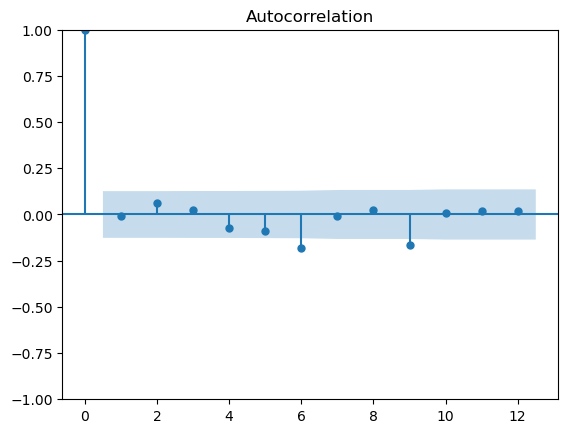

In [132]:
#Plot Autocorrelation of Residuals
plot_acf(residuals, lags=12)
plt.show()

In [133]:
# Summary statistics of residuals
print(residuals.describe())

                0
count  240.000000
mean     0.307432
std      5.772526
min    -23.808289
25%     -2.421174
50%      0.425254
75%      3.252695
max     20.036315


## Forecast Exogenous Variable

In [113]:
df_exog=train_df_nix[[ "Food Price Index","ds","unique_id"]]
df_exog.columns = ["y","ds","unique_id"]

In [114]:
#Get forecast of  exogenous variable for next 31 months using a HoltWinters method
models_3 = [DynamicOptimizedTheta(season_length=12, decomposition_type="additive", alias="Theta")]
sf_exog = StatsForecast(df=df_exog,
                   models=models_3,
                   freq='M', # monthly frequency
                   n_jobs=-1)

In [115]:
df_forecast_EXOG = pd.DataFrame()
df_forecast_EXOG["ds"] = test_df_nix["ds"]
df_forecast_EXOG["Food Price Index"] = sf_exog.forecast(31)["Theta"].values
df_forecast_EXOG["unique_id"] = 1
df_forecast_EXOG.head()

,ds,Food Price Index,unique_id
240,2012-01-01,164.586304,1
241,2012-02-01,165.633514,1
242,2012-03-01,166.318466,1
243,2012-04-01,167.521210,1
244,2012-05-01,168.637009,1


In [116]:
len(df_forecast_EXOG)

31

In [117]:
#Get forecast
arima_forecast_fuel = sf_4.forecast(h=31, X_df = df_forecast_EXOG)

In [118]:
forecasts_df['AutoARIMA_Exog_Food']=arima_forecast_fuel['AutoARIMA']
forecasts_df.head()

,ds,Seasonal Naive,HoltWinters,Theta,actual_data,arima_forecast,AutoARIMA,AutoARIMA_Exog_All,AutoARIMA_Exog_Food
unique_id,,,,,,,,,
1,2011-12-31,173.296112,195.270615,196.932907,199.691044,195.859212,195.600555,197.796753,196.586472
1,2012-01-31,181.529999,195.364746,197.747223,208.646372,195.411436,195.473145,199.140030,197.438599
1,2012-02-29,198.746613,198.966217,201.087601,216.976382,195.200180,195.469345,202.351608,198.000885
1,2012-03-31,212.574097,200.724304,204.193329,210.621955,195.100512,195.452576,205.700455,198.994568
1,2012-04-30,199.947372,199.691040,205.598862,194.234473,195.053489,195.446472,207.106735,199.917236


In [119]:
#Evaluate the model MAE
model_mae = np.round(mean_absolute_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA_Exog_Food"]),2)
#Evaluate the model MAPE
model_mape = np.round(100*mean_absolute_percentage_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA_Exog_Food"]),2)
#Evaluate the model MSE
model_mse = np.round(mean_squared_error(forecasts_df["actual_data"], forecasts_df["AutoARIMA_Exog_Food"]),2)

In [120]:
#Save errors in error dataframe
error_df.loc[:,"AutoARIMA_Exog_Food"] = (model_mae, model_mape, model_mse)
error_df

,Seasonal Naive,HoltWinters,Theta,ARIMA,AutoARIMA,AutoARIMA_Exog_All,AutoARIMA_Exog_Food
MAE,11.72,13.49,20.4,6.15,6.37,21.26,7.44
MAPE,6.1,7.07,10.7,3.20,3.32,11.16,3.91
MSE,200.52,223.18,489.28,71.98,74.47,536.49,93.18


In [121]:
train_df

,ds,unique_id,y
0,1992-01-01,1,35.061062
1,1992-02-01,1,35.068909
2,1992-03-01,1,34.613325
3,1992-04-01,1,36.682118
4,1992-05-01,1,38.185955
...,...,...,...
235,2011-08-01,1,189.649441
236,2011-09-01,1,190.448613
237,2011-10-01,1,189.215516
238,2011-11-01,1,197.215668


### Model Fit Data

In [122]:
#See fitted values from the models
result_auto_arima = sf_2.fitted_[0,0].model_
result_exog_all = sf_3.fitted_[0,0].model_
result_exog_food = sf_4.fitted_[0,0].model_


fitted_df["fitted_auto_arima"] = result_auto_arima.get("x")
fitted_df["fitted_exog_all"] = result_exog_all.get("x")
fitted_df["fitted_exog_food"] = result_exog_food.get("x")

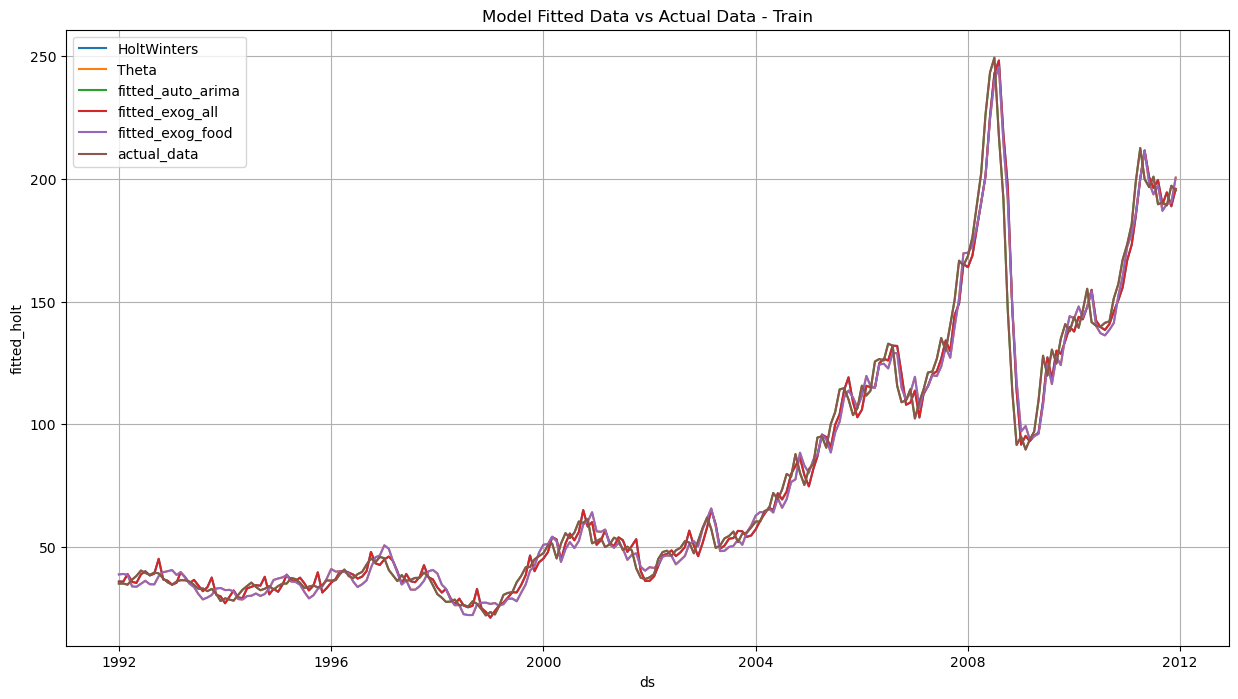

In [123]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,8))

sns.lineplot(data=fitted_df, x="ds", y="fitted_holt", label="HoltWinters")
sns.lineplot(data=fitted_df, x="ds", y="fitted_theta", label="Theta")
sns.lineplot(data=fitted_df, x="ds", y="fitted_auto_arima", label="fitted_auto_arima")
sns.lineplot(data=fitted_df, x="ds", y="fitted_holt", label="fitted_exog_all")
sns.lineplot(data=fitted_df, x="ds", y="fitted_theta", label="fitted_exog_food")
sns.lineplot(data=train_df, x="ds", y="y", label="actual_data")
plt.grid()
plt.title("Model Fitted Data vs Actual Data - Train")
plt.show()

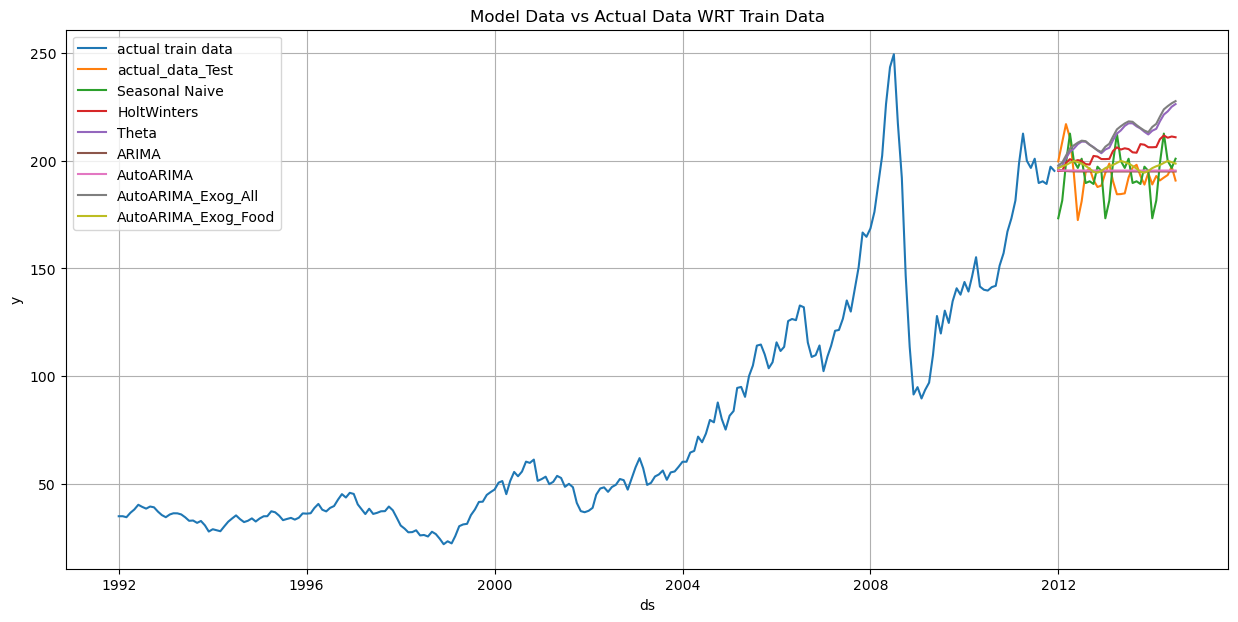

In [134]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,7))
sns.lineplot(data=train_df, x="ds", y="y", label="actual train data")
sns.lineplot(data=forecasts_df, x="ds", y="actual_data", label="actual_data_Test")
sns.lineplot(data=forecasts_df, x="ds", y="Seasonal Naive", label="Seasonal Naive")
sns.lineplot(data=forecasts_df, x="ds", y="HoltWinters", label="HoltWinters")
sns.lineplot(data=forecasts_df, x="ds", y="Theta", label="Theta")
sns.lineplot(data=forecasts_df, x="ds", y="arima_forecast", label="ARIMA")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA", label="AutoARIMA")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA_Exog_All", label="AutoARIMA_Exog_All")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA_Exog_Food", label="AutoARIMA_Exog_Food")
plt.grid()

plt.title("Model Data vs Actual Data WRT Train Data")
plt.show()

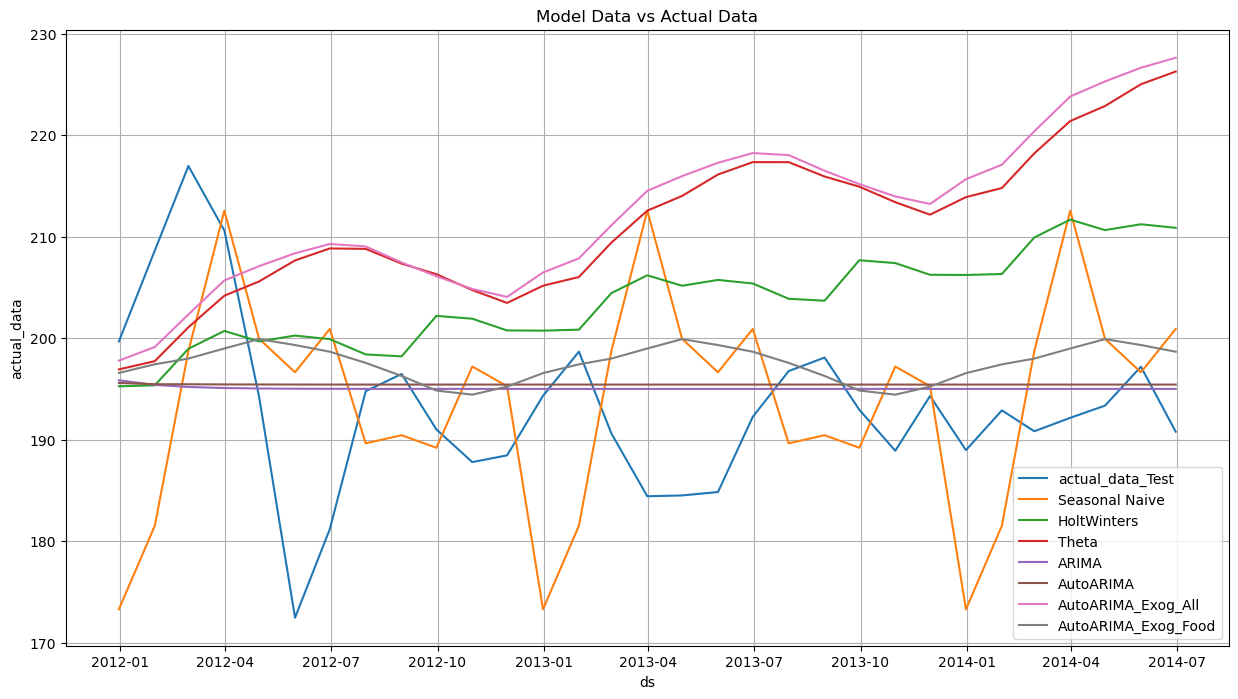

In [125]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,8))

sns.lineplot(data=forecasts_df, x="ds", y="actual_data", label="actual_data_Test")
sns.lineplot(data=forecasts_df, x="ds", y="Seasonal Naive", label="Seasonal Naive")
sns.lineplot(data=forecasts_df, x="ds", y="HoltWinters", label="HoltWinters")
sns.lineplot(data=forecasts_df, x="ds", y="Theta", label="Theta")
sns.lineplot(data=forecasts_df, x="ds", y="arima_forecast", label="ARIMA")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA", label="AutoARIMA")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA_Exog_All", label="AutoARIMA_Exog_All")
sns.lineplot(data=forecasts_df, x="ds", y="AutoARIMA_Exog_Food", label="AutoARIMA_Exog_Food")
plt.grid()

plt.title("Model Data vs Actual Data")
plt.show()